In [26]:
from pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import core
import time
import util
import matplotlib.pylab as pylab
from importlib import reload

DPI = 120
IMG_PATH_PREFIX = 'writeup/images/'

def save_fig(fig, file_prefix):
  fig.tight_layout()
  fig.savefig(f"{IMG_PATH_PREFIX}{file_prefix}.png", format='png', dpi=DPI, bbox_inches='tight')

params = {
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
          }
pylab.rcParams.update(params)

In [4]:
data_path = "data/reaction_diffusion_big.mat"
# Train data uses 0 to T_TRAIN-1. Test data uses the rest.
T_TRAIN = 151

data = read_mat(data_path)
# T = 201, X, Y = 512.
# u[x,y,t], v[x,y,t]
t_list, x_list, y_list, u_mat, v_mat = data['t'], data['x'], data['y'], data['u'], data['v']
u_mat_train = u_mat[:,:,:T_TRAIN]
u_mat_test = u_mat[:,:,T_TRAIN:]
v_mat_train = v_mat[:,:,:T_TRAIN]
v_mat_test = v_mat[:,:,T_TRAIN:]
w_mat_train = core.uv_to_wmat(u_mat_train, v_mat_train)
w_mat_test = core.uv_to_wmat(u_mat_test, v_mat_test)

# Show original u,v, one snapshot

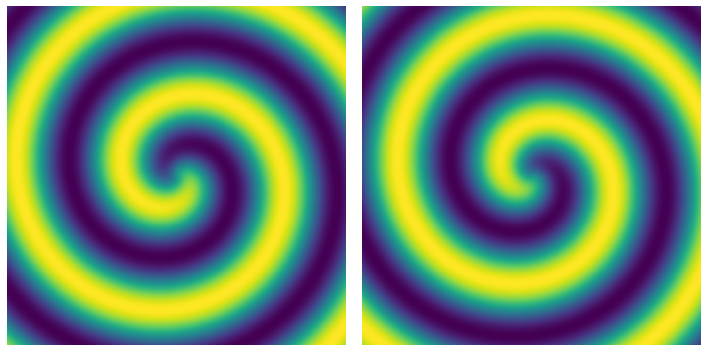

In [10]:
fig = util.plot_w(w_mat_train[:,0])
save_fig(fig, "rd_data_snapshot")

# SVD. Energy and modes

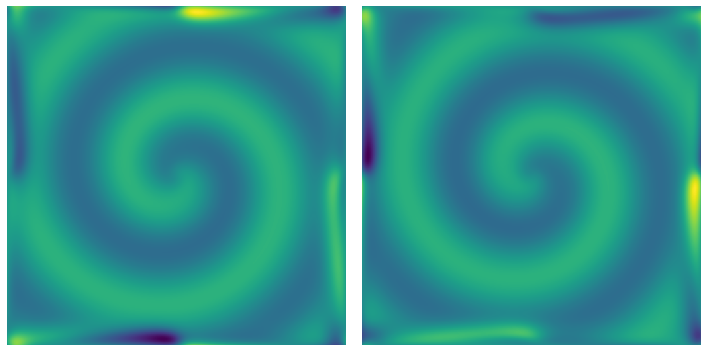

In [11]:
avg_w = w_mat_train.mean(axis = 1)
fig = util.plot_w(avg_w)
save_fig(fig, "rd_train_avg")

In [12]:
w_mat_train_avg_removed =  (w_mat_train.T - avg_w).T

In [13]:
start_time = time.time()
w_modes, s, vh = np.linalg.svd(w_mat_train_avg_removed, full_matrices=False)
print(f"SVD takes {time.time() - start_time} s")

SVD takes 12.40192985534668 s


Need 2 modes to cover 90 energy
Need 2 modes to cover 95 energy
Need 3 modes to cover 99 energy
Need 4 modes to cover 99.9 energy


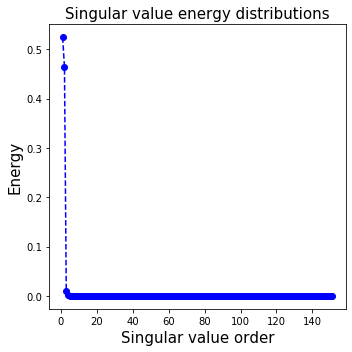

In [14]:
fig = core.plot_energy_from_singular_values(s)
save_fig(fig, "rd_energy")

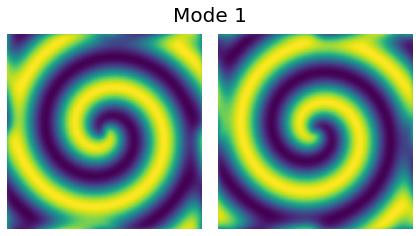

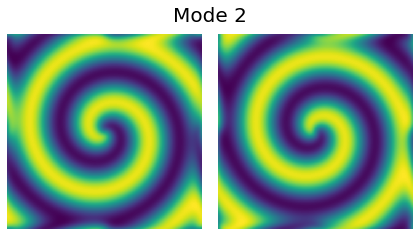

In [27]:
reload(util)
for mode in range(2):
  fig = util.plot_w(w_modes[:,mode])
  fig.suptitle(f"Mode {mode+1}", fontsize = 20, y=1.08)
  save_fig(fig, f"rd_mode_{mode+1}")

# Reconstruction with 4 ranks

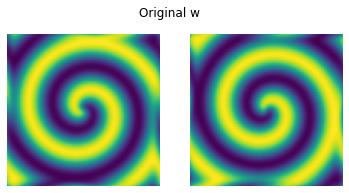

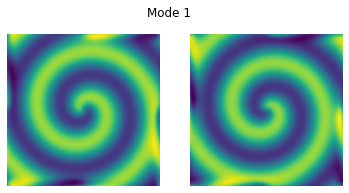

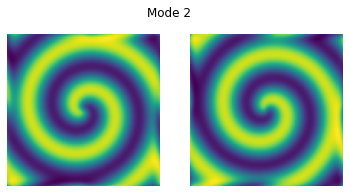

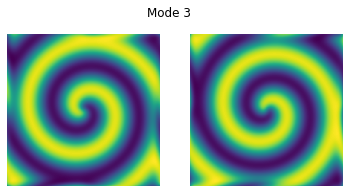

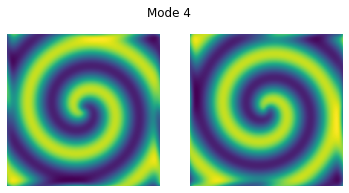

In [28]:
max_rank = 4
original_w_vec = w_mat_train[:,50]
fig = util.plot_w(original_w_vec)
fig.suptitle("Original w")
for rank in range(0, max_rank):
  w_modes_r = w_modes[:,:rank+1]
  recon_w_vec = avg_w + w_modes_r @ (w_modes_r.T @ original_w_vec)
  fig = util.plot_w(recon_w_vec)  
  fig.suptitle(f"Mode {rank+1}")

# Training in 4 modes

In [29]:
lowd_w_mat_train = w_modes_r.T @ w_mat_train_avg_removed
lowd_w_mat_train.shape

(4, 151)

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

train_input, train_output = core.u_mat_to_regression(lowd_w_mat_train)
num_space = lowd_w_mat_train.shape[0]
def build_model(l2_reg, num_space):
  model = tf.keras.Sequential()
  # Input = (num_space,) = U(x, t)
  N = 500
  model.add(layers.Dense(N, activation='relu', input_shape=(num_space,)))
  model.add(layers.Dense(N, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
  model.add(layers.Dense(N, activation='relu'))
  # Output = (numspace,) = U(x, t + dt)
  model.add(layers.Dense(num_space))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mse'])
  return model

In [11]:
# Cross validate
for l2_reg in [1e-4, 1e-3, 1e-2]:
  model = build_model(l2_reg, num_space)
  mse = core.get_kfold_mse(model, train_input, train_output)
  print(f"L2 reg= {l2_reg}, kfold mse = {mse}")

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 1s 5ms/sample - loss: 36548.2729 - mse: 36548.2539
Epoch 2/10
100/100 [==============================] - 0s 505us/sample - loss: 19230.8064 - mse: 19230.7852
Epoch 3/10
100/100 [==============================] - 0s 506us/sample - loss: 7605.5673 - mse: 7605.5444
Epoch 4/10
100/100 [==============================] - 0s 488us/sample - loss: 7497.1660 - mse: 7497.1406
Epoch 5/10
100/100 [==============================] - 0s 438us/sample - loss: 6170.1400 - mse: 6170.1133
Epoch 6/10
100/100 [==============================] - 0s 443us/sample - loss: 1921.4936 - mse: 1921.4648
Epoch 7/10
100/100 [==============================] - 0s 391us/sample - loss: 1602.4936 - mse: 1602.4639
Epoch 8/10
100/100 [==============================] - 0s 465us/sample - loss: 2024.9647 - mse: 2024.9341
Epoch 9/10
100/100 [==============================] - 0s 613us/sample - loss: 1046.6739 - mse: 1046.6427
Epoch 10/10
50/50 [=============

In [37]:
best_l2_reg = 1e-2
best_model = build_model(best_l2_reg, num_space)
best_model.fit(train_input, train_output, epochs=100, batch_size=32, shuffle=True)

Train on 150 samples
Epoch 1/100
150/150 [==============================] - 0s 3ms/sample - loss: 45138.1982 - mse: 45136.2031
Epoch 2/100
150/150 [==============================] - 0s 426us/sample - loss: 14624.8754 - mse: 14622.8984
Epoch 3/100
150/150 [==============================] - 0s 427us/sample - loss: 3189.1857 - mse: 3187.2083
Epoch 4/100
150/150 [==============================] - 0s 466us/sample - loss: 3888.4030 - mse: 3886.4363
Epoch 5/100
150/150 [==============================] - 0s 304us/sample - loss: 1108.5363 - mse: 1106.5906
Epoch 6/100
150/150 [==============================] - 0s 693us/sample - loss: 1802.8655 - mse: 1800.9329
Epoch 7/100
150/150 [==============================] - 0s 375us/sample - loss: 392.3103 - mse: 390.3836
Epoch 8/100
150/150 [==============================] - 0s 329us/sample - loss: 644.8520 - mse: 642.9306
Epoch 9/100
150/150 [==============================] - 0s 483us/sample - loss: 211.5240 - mse: 209.6117
Epoch 10/100
150/150 [=======

# Testing given initial condition

In [38]:
w_mat_test_avg_removed =  (w_mat_test.T - avg_w).T
lowd_w_mat_test = w_modes_r.T @ w_mat_test_avg_removed
lowd_w_mat_test.shape

(4, 50)

In [39]:
wt = lowd_w_mat_test[:,0:1]
num_time = lowd_w_mat_test.shape[1]
pred_w_mat = core.create_pred_u_mat(wt, best_model, num_time)

t = 10
t = 20
t = 30
t = 40
NN prediction of u(x,t) takes 2.394381523132324 s


In [40]:
pred_w_mat.shape

(4, 50)

In [41]:
highd_pred_w_mat = w_modes_r @ pred_w_mat

In [42]:
actual_pred_w_mat = (highd_pred_w_mat.T + avg_w.T).T

In [43]:
actual_pred_w_mat.shape

(524288, 50)

In [44]:
w_mat_test.shape

(524288, 50)

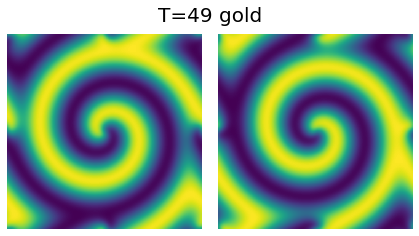

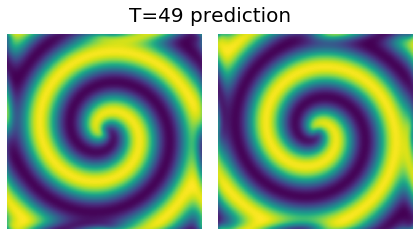

In [49]:
t = 49
fig = util.plot_w(w_mat_test[:,t])
fig.suptitle(f"T=49 gold", fontsize = 20, y=1.08)
save_fig(fig, "rd_test_49_gold")
fig = util.plot_w(actual_pred_w_mat[:,t])
fig.suptitle(f"T=49 prediction", fontsize = 20, y=1.08)
save_fig(fig, "rd_test_49_pred")

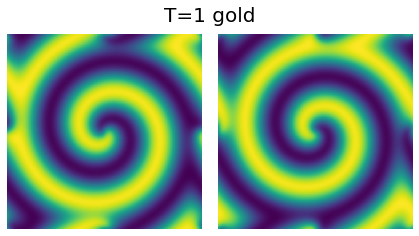

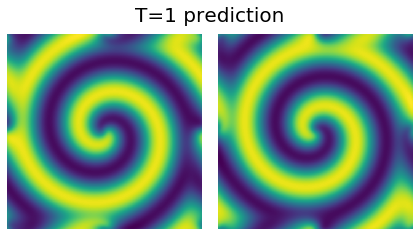

In [50]:
t = 1
fig = util.plot_w(w_mat_test[:,t])
fig.suptitle(f"T=1 gold", fontsize = 20, y=1.08)
save_fig(fig, "rd_test_1_gold")
fig = util.plot_w(actual_pred_w_mat[:,t])
fig.suptitle(f"T=1 prediction", fontsize = 20, y=1.08)
save_fig(fig, "rd_test_1_pred")